# Geometric Sample Bias

Seminal work by Terzaghi (1965) revealed a geometric bias generated 
by sampling a three-dimensional fracture network with a line. 
Simply put, fractures planes that are perpendicular to the line are 
very likely to be intersected whereas those parallel to the line are 
almost never intersected. This geometric sample bias generates a 'blind
zone' in fracture datasets where those which are near-parallel to the
scan-line or well-path are rarely sampled. This blind zone is 
sometimes also referred to as the 'well shadow'.

Terzaghi (1965) proposed a methodology quantifies the geometric sample 
bias using the acute angle (alpha) between the fracture plane and 
the line. Visualising the blind zone (where sin(alpha) +/- 0.3) and 
contours of sample bias (isogenic contours) on a stereonet enables
us to visually evaluate the degree that geometric sample bias in 
affects a fracture dataset.  

A weighting may be applied based on the alpha angle which may correct
the sampled fracture population to something more reflective of actual
frequency. This kind of correction is common-place in modern image log
analysis and some form of the Terzaghi correction comes baked into 
most log analysis software. However, there are two key issues with these
corrections:

-   Correction may mislead interpretation by emphasising solitary 
    fractures that are not part of some significant but under-sampled 
    population, especially where the weighting factor approaches 
    infinity near sin α = 0. Priest (1993) recommends resolving this 
    by using an upper limit of sin α = 0.1 when weighting.

-   Correction can only be applied to those fractures which were sampled
    and therefore does a poor job of correcting in the blind zone where
    fractures are rarely sampled.

fractoolbox includes functions that (1) weight fracture populations to 
reduce the impact of geometric sample bias and (2) construct isogenic 
contours for stereonets so the effect of sample bias and the blind 
zone are visible to the interpreter. The code in this notebook 
illustrates how these functions are strung together to analyse  
fracture data picked from a borehole image log.  

Refer to Wallis et al. (2020)
for examples of these methods as applied micro-resistivity image 
logs acquired in seven high-temperature geothermal wells.

In [2]:
import fractoolbox as ftb

from matplotlib import pyplot as plt
import numpy as np
import math
import pandas as pd
import mplstereonet

%matplotlib inline

## Calculate isogenic contour elements and fracture weighting


In [3]:
# import survey data
dfsurvey = pd.read_csv(r'testdata-survey.csv')

# add a plunge column to the survey data
dfsurvey['plunge'] = 90 - dfsurvey['inclination_deg']

# import the image log data
dffracture = pd.read_csv(r'testdata-fractures.csv')

# calculate strike using right hand rule
strike = [] 
for n in dffracture['dipazimuth_deg']:
    strike.append(ftb.dip2strike(n))
dffracture['strike360'] = strike

# append well plunge 
mDdat = dffracture['depth_mMDRF']
mDsur = dfsurvey['depth_mMDRF']
xsur = dfsurvey['easting_m']
ysur = dfsurvey['northing_m']
zsur = dfsurvey['plunge']

dfxyz1 = ftb.xyzinterp(mDdat, mDsur, xsur, ysur, zsur) 
dfxyz1.columns = ['Dpth_mMDRT_1','Northing_1','Easting_1','wellplunge']
dffracture = pd.concat([dffracture,dfxyz1], axis=1, join='inner')

# append well azumuth 
mDdat = dffracture['depth_mMDRF']
mDsur = dfsurvey['depth_mMDRF']
xsur = dfsurvey['easting_m']
ysur = dfsurvey['northing_m']
zsur = dfsurvey['azimuth_deg']

dfxyz2 = ftb.xyzinterp(mDdat, mDsur, xsur, ysur, zsur) 
dfxyz2.columns = ['Dpth_mMDRT_2','Northing_2','Easting_2','wellazi']
dffracture = pd.concat([dffracture,dfxyz2], axis=1, join='inner')

# drop excess coloumns
dffracture = dffracture.drop(['Dpth_mMDRT_2','Northing_2','Easting_2','Dpth_mMDRT_1','Northing_1','Easting_1',],1)

# calculate the unit vectors for the well at each fracture depth
dffracture['wx'] = ftb.unitvectorx(dffracture['wellazi'],dffracture['wellplunge'])
dffracture['wy'] = ftb.unitvectory(dffracture['wellazi'],dffracture['wellplunge'])
dffracture['wz'] = ftb.unitvectorz(dffracture['wellazi'],dffracture['wellplunge'])

# calculate the unit vectors for the fracture dip/dipaz
dffracture['fx'] = ftb.unitvectorx(dffracture['dipazimuth_deg'],dffracture['dip_deg'])
dffracture['fy'] = ftb.unitvectory(dffracture['dipazimuth_deg'],dffracture['dip_deg'])
dffracture['fz'] = ftb.unitvectorz(dffracture['dipazimuth_deg'],dffracture['dip_deg'])

# calculate alpha angle between the well and fracture
dffracture['alpha'] = np.arccos(
    dffracture['wx']*dffracture['fx'] + 
    dffracture['wy']*dffracture['fy'] + 
    dffracture['wz']*dffracture['fz'] 
    )

# calculate sin(aplha)
dffracture['sin(alpha)'] = np.sin(dffracture['alpha'])

# calculate the weighting
dffracture['weight'] = 1 / dffracture['sin(alpha)']

# trim the survey data to logged interval
dfsurveytrimmed = dfsurvey[
    (dfsurvey.depth_mMDRF < 2152) & 
    (dfsurvey.depth_mMDRF > 1219)
    ]

# calculate the isogenic contour for mean well plunge & azumuth
wpl = dfsurveytrimmed['plunge'].mean()
waz = dfsurveytrimmed['azimuth_deg'].mean()

strikeX,dipX = ftb.isogeniccontour(wpl, waz, 1) 
strike9,dip9 = ftb.isogeniccontour(wpl, waz, 0.9) 
strike8,dip8 = ftb.isogeniccontour(wpl, waz, 0.8) 
strike7,dip7 = ftb.isogeniccontour(wpl, waz, 0.7) 
strike6,dip6 = ftb.isogeniccontour(wpl, waz, 0.6) 
strike5,dip5 = ftb.isogeniccontour(wpl, waz, 0.5)
strike4,dip4 = ftb.isogeniccontour(wpl, waz, 0.4) 
strike3,dip3 = ftb.isogeniccontour(wpl, waz, 0.3) 
strike2,dip2 = ftb.isogeniccontour(wpl, waz, 0.2) 
strike1,dip1 = ftb.isogeniccontour(wpl, waz, 0.1)
strike0,dip0 = ftb.isogeniccontour(wpl, waz, 0)

# print number of fractures
# -------------------------
print('N = ',dffracture.shape)

N =  (1142, 16)


# Poles and isogenic contours

Isogenic contours for the test data show moderate impact from the blind zone. The presence of the approximately northwest-striking fractures within the blind sone indicates that there is likely a strong, high-angle cluster. refer to fractoolbox/published-case-study/2-stereonets.ipynb to see a range of case studies and how they are impacted by the blind zone. 

[]

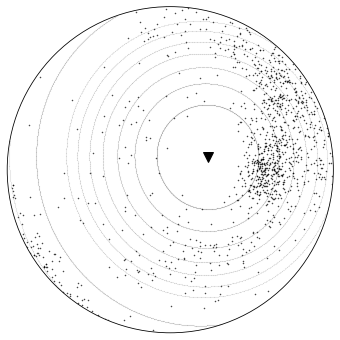

In [4]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111, projection='equal_area_stereonet')

ax1.pole(dffracture.strike360, dffracture.dip_deg, color='k', markersize=0.5, alpha=0.8)

# plot the isogenic contours
ms = 0.06
for ax in [ax1]:
    ax.pole(strike0,dip0,'.',markersize=ms,color='k') 
    #ax.pole(strike1,dip1,'.',markersize=ms,color='k') 
    #ax.pole(strike2,dip2,'.',markersize=ms,color='k') 
    ax.pole(strike3,dip3,'.',markersize=ms,color='k') 
    ax.pole(strike4,dip4,'.',markersize=ms,color='k') 
    ax.pole(strike5,dip5,'.',markersize=ms,color='k') 
    ax.pole(strike6,dip6,'.',markersize=ms,color='k') 
    ax.pole(strike7,dip7,'.',markersize=ms,color='k') 
    ax.pole(strike8,dip8,'.',markersize=ms,color='k') 
    ax.pole(strike9,dip9,'.',markersize=ms,color='k') 
    ax.pole(strikeX,dipX,'.',markersize=ms,color='k') 

# plot the well
ax1.line(wpl,waz,marker='v',markersize=10,color='k')

# remove labels
ax1.set_azimuth_ticklabels([])

# Contoured poles: Raw frequency

Contouring poles reveals a strong fracture cluster with a north-striking centre. The northwest-striking high angle cluster contains a much smaller number of fractures fractures.

[]

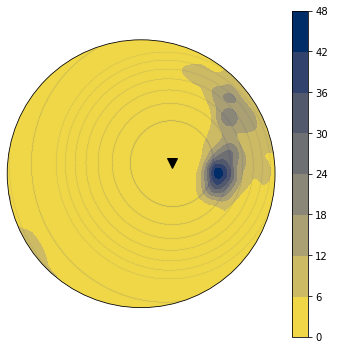

In [5]:
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111, projection='equal_area_stereonet')

ucor = ax2.density_contourf(
    dffracture.strike360, 
    dffracture.dip_deg, 
    #vmin=0., vmax=50., # fixes colour bar range 
    measurement='poles', 
    cmap='cividis_r')

# add the colour bar
fig.colorbar(ucor)

# plot the isogenic contours
ms = 0.03
c = '#3c5295'
for ax in [ax2]:
    ax.pole(strike0,dip0,'.',markersize=ms,color=c) 
    #ax.pole(strike1,dip1,'.',markersize=ms,color=c) 
    #ax.pole(strike2,dip2,'.',markersize=ms,color=c) 
    ax.pole(strike3,dip3,'.',markersize=ms,color=c) 
    ax.pole(strike4,dip4,'.',markersize=ms,color=c) 
    ax.pole(strike5,dip5,'.',markersize=ms,color=c) 
    ax.pole(strike6,dip6,'.',markersize=ms,color=c) 
    ax.pole(strike7,dip7,'.',markersize=ms,color=c) 
    ax.pole(strike8,dip8,'.',markersize=ms,color=c) 
    ax.pole(strike9,dip9,'.',markersize=ms,color=c) 
    ax.pole(strikeX,dipX,'.',markersize=ms,color=c) 

# plot the well
ax2.line(wpl,waz,marker='v',markersize=10,color='k')

# remove labels
ax2.set_azimuth_ticklabels([])

# Contoured poles: Terzaghi weighted frequency

Contouring the weighted poles indicates that the high-angle, northwest-striking cluster may be as important as the lower angle north-striking cluster which is dominant in the raw data. This means that both trends should be considered when applying these data to interpreting reservoir structure and patterns of fluid flow. 

[]

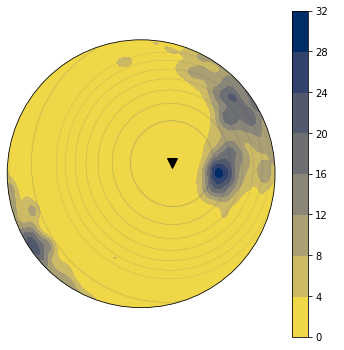

In [6]:
fig = plt.figure(figsize=(6,6))
ax3 = fig.add_subplot(111, projection='equal_area_stereonet')

w = dffracture['weight'].to_list()

cor = ax3.density_contourf(
    dffracture.strike360, 
    dffracture.dip_deg,
    #vmin=0., vmax=50., # fixes colour bar range 
    measurement='poles',
    weights=w, 
    cmap='cividis_r')

fig.colorbar(cor) 

# plot isogenic contours
ms = 0.03
c = '#3c5295'
for ax in [ax3]:
    ax.pole(strike0,dip0,'.',markersize=ms,color=c) 
    #ax.pole(strike1,dip1,'.',markersize=ms,color=c) 
    #ax.pole(strike2,dip2,'.',markersize=ms,color=c) 
    ax.pole(strike3,dip3,'.',markersize=ms,color=c) 
    ax.pole(strike4,dip4,'.',markersize=ms,color=c) 
    ax.pole(strike5,dip5,'.',markersize=ms,color=c) 
    ax.pole(strike6,dip6,'.',markersize=ms,color=c) 
    ax.pole(strike7,dip7,'.',markersize=ms,color=c) 
    ax.pole(strike8,dip8,'.',markersize=ms,color=c) 
    ax.pole(strike9,dip9,'.',markersize=ms,color=c) 
    ax.pole(strikeX,dipX,'.',markersize=ms,color=c)  

# plot the well
ax3.line(wpl,waz,marker='v',markersize=10,color='k')

# remove labels
ax3.set_azimuth_ticklabels([])

### Synthetic fracture dataset

dips 0-90 at 10 degree intervals (10 dips)

strikes 0-360 at 10 degree intervals and excluding 360 (36 strikes)

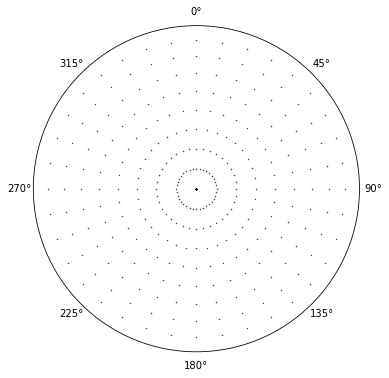

In [91]:
dipset = list(np.linspace(0,90,num=9,endpoint=False)) * 36
strikeset = list(np.repeat(np.linspace(0,360,num=36,endpoint=False),9))

fig = plt.figure(figsize=(6,6))
ax4 = fig.add_subplot(111, projection='equal_area_stereonet')
ax4.pole(strikeset, dipset, color='k', markersize=0.5, alpha=0.8)


[]

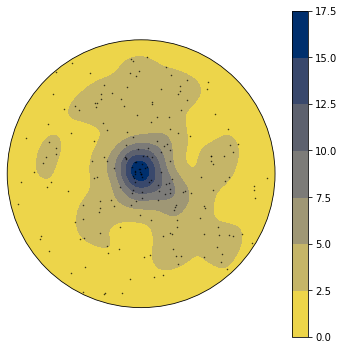

In [90]:

# Generate a random scatter of fractures
size = 200
random_strikes = np.random.randint(0, 360, size=size)
random_dips = np.random.randint(0, 90, size=size)

fig = plt.figure(figsize=(6,6))
ax5 = fig.add_subplot(111, projection='equal_area_stereonet')
ax5.pole(random_strikes, random_dips, color='k', markersize=0.5, alpha=0.8)

cor = ax5.density_contourf(
    random_strikes, 
    random_dips,
    #vmin=0., vmax=50., # fixes colour bar range 
    measurement='poles',
    cmap='cividis_r')

fig.colorbar(cor)

ax5.set_azimuth_ticklabels([]) 

(array([1., 1., 2., 2., 4., 2., 2., 1., 1., 2., 1., 5., 3., 2., 4., 5., 2.,
        3., 2., 2., 2., 5., 1., 2., 3., 3., 3., 1., 3., 3., 5., 1., 4., 2.,
        0., 3., 0., 0., 1., 1., 1., 3., 3., 2., 0., 2., 3., 2., 2., 1., 3.,
        1., 3., 5., 4., 2., 6., 4., 2., 2., 1., 3., 3., 1., 0., 3., 2., 3.,
        1., 1., 2., 0., 4., 1., 4., 1., 1., 3., 2., 1., 4., 2., 4., 2., 0.,
        0., 1., 3., 1., 5.]),
 array([  1.        ,   4.94444444,   8.88888889,  12.83333333,
         16.77777778,  20.72222222,  24.66666667,  28.61111111,
         32.55555556,  36.5       ,  40.44444444,  44.38888889,
         48.33333333,  52.27777778,  56.22222222,  60.16666667,
         64.11111111,  68.05555556,  72.        ,  75.94444444,
         79.88888889,  83.83333333,  87.77777778,  91.72222222,
         95.66666667,  99.61111111, 103.55555556, 107.5       ,
        111.44444444, 115.38888889, 119.33333333, 123.27777778,
        127.22222222, 131.16666667, 135.11111111, 139.05555556,
        143.  

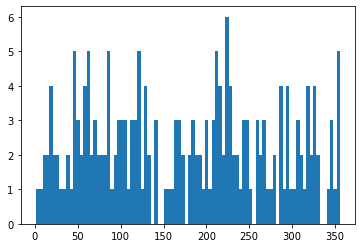

In [109]:
plt.hist(random_strikes,bins=90)

(array([3., 1., 1., 2., 4., 3., 2., 3., 2., 0., 0., 4., 3., 3., 1., 4., 2.,
        2., 2., 4., 3., 1., 3., 2., 2., 2., 1., 2., 1., 5., 2., 1., 1., 3.,
        2., 3., 3., 1., 1., 2., 1., 3., 1., 1., 3., 0., 6., 3., 2., 1., 1.,
        2., 4., 2., 4., 3., 7., 5., 1., 2., 2., 4., 3., 4., 2., 1., 2., 3.,
        3., 3., 3., 1., 1., 1., 2., 4., 1., 2., 2., 2., 5., 1., 0., 1., 2.,
        1., 1., 0., 2., 1., 1.]),
 array([ 0.        ,  0.97802198,  1.95604396,  2.93406593,  3.91208791,
         4.89010989,  5.86813187,  6.84615385,  7.82417582,  8.8021978 ,
         9.78021978, 10.75824176, 11.73626374, 12.71428571, 13.69230769,
        14.67032967, 15.64835165, 16.62637363, 17.6043956 , 18.58241758,
        19.56043956, 20.53846154, 21.51648352, 22.49450549, 23.47252747,
        24.45054945, 25.42857143, 26.40659341, 27.38461538, 28.36263736,
        29.34065934, 30.31868132, 31.2967033 , 32.27472527, 33.25274725,
        34.23076923, 35.20879121, 36.18681319, 37.16483516, 38.14285714,
  

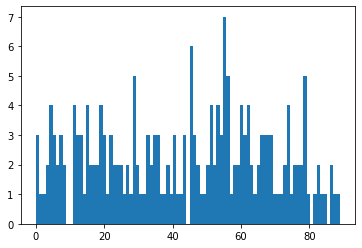

In [106]:
plt.hist(random_dips,bins=91)

## Citations

Terzaghi, R. D., 1965, Sources of error in joint surveys: Geotechnique, 
    v. 15, no. 3, p. 287-304.

Wallis, I.C., Rowland, J. V. and Dempsey, D. E., Allan, G., Sidik, R., 
    Martikno, R., McLean, K., Sihotang, M., Azis, M. and Baroek, M. 
    2020 (submitted) Approaches to imaging feedzone diversity with 
    case studies from Sumatra, Indonesia, and the Taupō Volcanic Zone, 
    New Zealand. New Zealand Geothermal Workshop: Waitangi, New Zealand.

In [7]:
%load_ext watermark
print('\n')
print('author:')
%watermark -a "Irene Wallis" -d
print('\n')
print('requirements:')
%watermark -v -p watermark,numpy,math,pandas,matplotlib,mplstereonet
print('\n')
print('fractoolbox.py')
print('\n')
%watermark -g



author:
Irene Wallis 2021-02-03


requirements:
CPython 3.7.7
IPython 7.15.0

watermark 2.0.2
numpy 1.18.1
math unknown
pandas 1.0.5
matplotlib 3.2.2
mplstereonet 0.6.dev0


fractoolbox.py


Git hash: 03b5f83a38631e7149905f8e5bd82eea0cca7171
